# **Assignment 1**


---







In [2]:
# Packages needed for this assignment
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# Introduction

The Environment

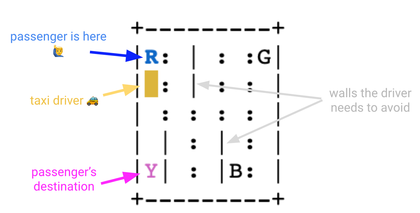




R, G, B, Y are locations on this map
The pipe symbol (|) represent walls
The colon symbol (:) represent open spaces

1.	The map is a 5x5 gridworld, leading to 25 locations.
2.	The alphabets R, G, B, Y are 4 locations.
3.	A passenger can be at any of the 4 locations.
4.	A passenger’s destination can be any of the left 3 locations.
5. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.
6.	The taxi can pass through **:** but not **|**
7.	The colon symbol **:** denotes a pass, which means, |B:a| if you’re at position **a** you can get to position **B** by going left.
8.	The pipe symbol **|** denotes a wall, which means, |Y|x: if you’re at position **x** you can’t get to position **Y** by going left.
9.	The environment rewards 20 points when a passenger is dropped to their destination.
10.	The environment penalizes -10 points if pickup operation is performed on a cell where there is no passenger.
11.	The environment penalizes -10 points if drop operation is performed if no passenger had boarded the taxi.
12.	The environment penalizes -1 for every other action.
13.	There are 500 states in this environment.

Each state answers these questions:
1.	Where is the taxi right now (one out of the 25 cells).
2.	Where is the passenger right now (one out of R,G,B,Y and the possibility of being inside the taxi).
3.	Where does the passenger want to go (one out of R,G,B,Y).

Initial conditions:
1.	At the start, the taxi will be at any of the 25 positions on the map.
2.	A passenger will be at any of R, G, B, Y locations.
3.	A destination will be at any of the R, G, B, Y locations.

Agent — Taxi

Our agent is a taxi, which can perform 6 actions:
0.	South
1.	North
2.  West
3.	East
4.	Pickup
5.	Dropoff

Expected behaviour

1.	The taxi must find the passenger traveling the shortest path.
2.	The taxi must pickup the passenger.
3.	The taxi must find the shortest path to the passenger’s destination.
4.	Drop the passenger at their destination traversing the shortest path


# Getting started with Open AI gym

[OpenAI Gym](http://gym.openai.com) is a toolkit for comparing RL-algorithms. It contains a wide variety of environments that you can train your agents on, and it is often used for benchmarking new methods in the RL research litterature. 
There are also [leaderboards](https://github.com/openai/gym/wiki/Leaderboard) for different gym-environments, showing which methods has been most successful so far.

In the assignments for this course we will make use of OpenAI gym (within the course's scope).

To test your installation of OpenAI gym, and learn about basic usage, we will look at the relatively simple Taxi-environment.

## Taxi driver - demo
In **this** environment there are four locations. Your job is to pick up a passenger at one of these locations, and then drop her of at another location. 

To test this environment run the following lines of code.

In [3]:
env = gym.make('Taxi-v3').env
state = env.reset()
print('Initial state:', state)

Initial state: 283


The methods used above are:
* `make()`: Creates a gym environment object. In this case we use the Taxi-environment.
* `reset()`: Resets the environment to an initial state, and returns the initial state. 
In the case of the Taxi-environment, the initial state is chosen randomly, so it will be different every time you run `env.reset()`.

To visualize the current state of the environment, you can use the function `render()`. In the Taxi-environment the visualization is text-based. 

In [4]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The filled square represents the taxi, the letters (R, G, Y and B) represents possible pickup and destination locations, and | represents a wall. The blue letter is the passenger, and the purple is the destination.

Next we take a look at the state space $\mathcal{S}$ (all possible states) and action space $\mathcal{A}$ (all possible actions). 

In [ ]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)



***Remark***: You may have noticed that gym uses `observation_space` instead of state space. For the purpose of this homework, the state space is the same as the observations space. However, in some problems the full state cannot be observed, so the space of possible states may not be the same as the space of possible observations. 

We next see how the agent can interact with the environment.

In [4]:
new_state, reward, done, info = env.step(1) # Take action 1 (north)
env.render()
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)
print("Info:", info)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
New state: 93
Reward: -1
Done: False
Info: {'prob': 1.0}
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


If it was possible, the taxi should now have moved one step north (if the taxi started at the top row then it will not move). The step-function returns the following information:
* __New state__: The state after the action is taken.
* __Reward__: The immediate reward. In the taxi-environment the reward for illegal "pickup" or "dropoff" is -10, successfully delivering the passenger gives +20, and any other action gives -1.
* __Done__: Is the environment done? In the Taxi-environment this will be false until the passenger is successfully dropped at her destination, or the number of actions taken gets larger than 200.
* __info__: Additional information mainly used for debugging.

The goal of the agent is thus to deliver the passanger to her destination in as few steps as possible. If more than 200 actions are taken, the agent has failed. 

One (quite bad) strategy for the taxi problem is to take a random action every time. Inside a gym-environment this can be done using `env.action_space.sample()`, which samples a random action from the action space. Look through the following loop and make sure that you understand what's going on. (We here use `clear_output()` to clear the output of the Jupyter cell, and `time.sleep()` to pause between each action)


Let's see what would happen if we try to brute-force our way to solving the problem.

Since we have our P table for default rewards in each state, we can try to have our taxi navigate just using that.

We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is 20. The env.action_space.sample() method automatically selects one random action from set of all possible actions.

In [7]:
def randomAgent(start_state):
  env.s = start_state # set environment to illustration's state
  epochs = 0
  penalties, reward = 0, 0

  frames = [] # for animation
  visited = []
  rewards = 0
  done = False
  while not done:
      action = env.action_space.sample()
      state, reward, done, info = env.step(action)
      
      while state in visited:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
      
      visited.append(state)
      rewards += reward
      if reward == -10:
          penalties += 1
      
      # Put each rendered frame into dict for animation
      frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }
      )
      

      epochs += 1
  return (frames,rewards)

 

frames,reward = randomAgent(328)
print("Reward incurred: {}".format(reward))

Reward incurred: -23


Printing created frames:

Note: we will be using this code to test your outputs

In [8]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(0.1)

In [9]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 44
State: 0
Action: 5
Reward: 20


As you can see, random actions is, unsurprisingly, not a good policy. However, what else can we do?

This is where you come in!

In this assignment you will be required to implement the following algorithms taught in class inorder to solve the problem.

Algorithms: 
1. Breadth First Search
2. Depth First Search
3. ID-DFS
4. W-A*
5. A* epsilon

Important to note!
*   Each agent should recive **state 328** as the initial state
*   Each agent should return a tuple: (frames,reward) 
1.   Frames: list of frames which would be able to be printed using the "print_frames" function which you were given.
2.   Reward: an integer which holds the total reward of the optimal (shortest) path



> For example, we will **test** your BFS agent code using the lines:
```
env.s = 328
frames,reward = bfs(env.s)
print_frames(frames)
print(reward)
```

*   Any other submision of code will cause the running of the notebook to fail and will result in a grade of 0 !



Some Tips (may be updated):
1. Folow the pseudo-code shown in the lectures this will help you greatly
2. Think about implementing a "node" class either a generic one or a different one for each search agent.
For example:
```
# BFS node:
class BFSNode:
        def __init__(self, frame=None, state=None, action=None, reward=None):
            self.frame = frame
            self.state = state
            self.action = action
            self.reward = reward


3. Think about implementing a "getNeighbours" function
For example:
```
def getNeigbours(node):
      env.s = node.state
      neighbours = []
      for action in range(6):
        new_state, reward, done, info = env.step(action) # Take action i
        new_node = (env.render(mode='ansi'),new_state,action,reward)
        neighbours.append(new_node)
        env.s = node.state
      return neighbours


4. Read the whole document before coding, this will help you plan ahead and cause less headaches in advance 


## 1. BFS
In this section please implement Breadth First Search like shown in class


In [ ]:
# use the algorithm learnt in class
# should return (frames,reward)

def bfs(first_state):
  # add implementation
  return 0       # remove me


"""
# driver code - for your use only, do not submit these lines!
env.s = 328
frames,reward = bfs(env.s)
print_frames(frames)
print(reward)
"""

## 2. DFS
In this section please implement Depth First Search like shown in class


In [ ]:
# use the algorithm learnt in class
# should return (frames,reward)

def dfs(first_state):
  # add implementation
  return 0       # remove me



"""
# driver code - for your use only, do not submit these lines!
env.s = 328
frames,reward = dfs(env.s)
print_frames(frames)
print(reward)
"""

## 3. ID-DFS
In this section please implement Iterative Deepening Depth First Search like shown in class

In [1]:
# use the algorithm learnt in class
# think about how to use dfs() foor your solution
# should return (frames,reward)

def id_dfs(first_state, depth):
  # add implementation
  return 0       # remove me


"""
# driver code - for your use only, do not submit these lines!
env.s = 328
initial_depth = 3 # random depth
frames,reward = id_dfs(env.s, initial_depth)
print_frames(frames)
print(reward)
"""

## 4. W-A*
In this section please implement W-A* like shown in class

In [ ]:
# use the algorithm learnt in class
# think about first impelmenting A*, check your solotion and then move on to A*
# note the heurisitcs needed to be implemented (instructions in dry pdf)
# should return (frames,reward)

def null_h(state):
  # add implementation
  return 0       # remove me

def chosen_h(state):
  # add implementation
  return 0       # remove me

def weighted_a_star(first_state,weight,heuristic_function):
  # add implementation
  return 0       # remove me




"""
# driver code - for your use only, do not submit these lines!
env.s = 328
weight = 3   # you will need to change this during the excersize 
frames,reward = frames = weighted_a_star(env.s,weight,admissible_h)
print_frames(frames)
print(reward)
frames,reward = frames = weighted_a_star(env.s,weight,non_admissible_h)
print_frames(frames)
print(reward)
"""

## 5. A*-epsilon
In this section please implement A*-epsilon like shown in class

In [ ]:
# use the algorithm learnt in class
# note the heurisitcs needed to be implemented (instructions in dry pdf)
# should return the frames like in random agent


def admissible_h(state):
  # add implementation
  return 0       # remove me

def non_admissible_h(state):
  # add implementation
  return 0       # remove me

def a_star_epsilon(first_state,weight,heuristic_function, epsilon):
  # add implementation
  return 0       # remove me




"""
# driver code - for your use only, do not submit these lines!
env.s = 328
weight = 3   # you will need to change this during the excersize 
epsilon = 9   # you will need to change this during the excersize

frames,reward = frames = a_star_epsilon(env.s,weight,admissible_h, epsilon)
print_frames(frames)
print(reward)

frames,reward = frames = a_star_epsilon(env.s,weight,non_admissible_h,epsilon )
print_frames(frames)
print(reward)
"""